# Pruning & Decomposition Sweep 결과 시각화

이 노트북은 `run_sparsity_sweep.sh` 스크립트를 통해 생성된 `wanda`와 `mi` 가지치기 방법론의 실험 결과를 시각화합니다.

**분석 내용:**
1. 다중 클래스 모델의 희소성(Sparsity)에 따른 정확도 변화
2. 분해(Decomposed)된 이진 모델의 타겟 클래스별 성능 비교
3. 특정 희소성 레벨에서의 방법론별 성능 요약
4. 원본 모델 대비 정확도 하락률 비교

## 1. 설정 및 데이터 로딩

실험 결과를 불러오기 위해 아래 `experiment_name` 변수를 자신의 디렉토리 이름과 일치하도록 수정하세요.

In [11]:
# --- Essential libraries for data handling and plotting ---

# For data manipulation and reading CSV files
import pandas as pd

# For creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt

# A high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

# For interacting with the operating system, like handling file paths
import os
from pathlib import Path


# --- Plotting style configurations ---

# Set a modern and clean plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

# Configure default figure sizes and font sizes for better readability
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [12]:
# --- 분석할 실험 설정 --- #
RESULTS_BASE_DIR = Path('./results_sparsity_sweep')
EXPERIMENT_NAME = 'bert_tiny_dbpedia_14'
METHODS = ['wanda', 'mi']
# ------------------------- #

experiment_path = RESULTS_BASE_DIR / EXPERIMENT_NAME

def load_experiment_data(path: Path, methods: list) -> pd.DataFrame:
    """지정된 실험 경로에서 모든 CSV 파일을 로드하여 단일 DataFrame으로 병합합니다."""
    all_dfs = []
    for method in methods:
        # The sweep script saves results for all target classes in one file per method
        csv_file = path / f"{EXPERIMENT_NAME}_{method}.csv"
        if csv_file.exists():
            df = pd.read_csv(csv_file)
            all_dfs.append(df)
        else:
            print(f"Warning: Could not find result file for method '{method}' at {csv_file}")
    
    if not all_dfs:
        raise FileNotFoundError(f"No CSV files found in {path} for methods {methods}")
    
    # Concatenate all data into a single dataframe
    full_df = pd.concat(all_dfs, ignore_index=True)
    return full_df

data = load_experiment_data(experiment_path, METHODS)

print("데이터 로딩 완료!")
print(f"총 {len(data)}개의 행이 로드되었습니다.")
data.head()

데이터 로딩 완료!
총 18개의 행이 로드되었습니다.


,method,target_sparsity,achieved_sparsity,accuracy,binary_accuracy,binary_target_class,exp,model_name,dataset,base_accuracy
0,wanda,0.1,0.095208,0.988429,0.702114,8,bert:tiny:dbpedia_14,prajjwal1/bert-tiny,dbpedia_14,0.988357
1,wanda,0.2,0.195706,0.988229,0.730286,8,bert:tiny:dbpedia_14,prajjwal1/bert-tiny,dbpedia_14,0.988357
2,wanda,0.3,0.296204,0.987814,0.740871,8,bert:tiny:dbpedia_14,prajjwal1/bert-tiny,dbpedia_14,0.988357
3,wanda,0.4,0.396702,0.986200,0.766814,8,bert:tiny:dbpedia_14,prajjwal1/bert-tiny,dbpedia_14,0.988357
4,wanda,0.5,0.497822,0.981229,0.756514,8,bert:tiny:dbpedia_14,prajjwal1/bert-tiny,dbpedia_14,0.988357


## 2. 다중 클래스 정확도 vs. 희소성

이 그래프는 가지치기 후 원래의 다중 클래스 분류 모델의 정확도가 희소성에 따라 어떻게 변하는지 보여줍니다. Y축의 점선은 가지치기 전 원본 모델의 정확도(Baseline)를 나타냅니다.

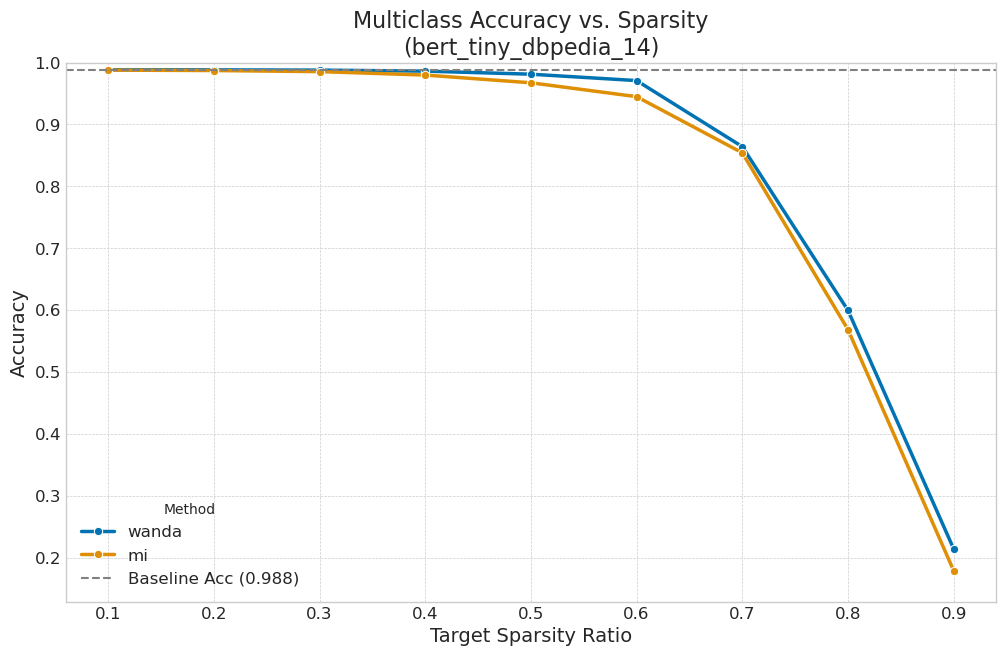

In [13]:
# Plotting multiclass accuracy vs. target sparsity
plt.figure(figsize=(12, 7))

# Get a representative subset for multiclass accuracy, as it's the same for all target classes
multiclass_df = data.drop_duplicates(subset=['method', 'target_sparsity'])

sns.lineplot(
    data=multiclass_df,
    x='target_sparsity',
    y='accuracy',
    hue='method',
    marker='o',
    linestyle='-',
    linewidth=2.5
)

# Add baseline accuracy line
baseline_acc = multiclass_df['base_accuracy'].iloc[0]
plt.axhline(y=baseline_acc, color='gray', linestyle='--', label=f'Baseline Acc ({baseline_acc:.3f})')

plt.title(f'Multiclass Accuracy vs. Sparsity\n({EXPERIMENT_NAME})')
plt.xlabel('Target Sparsity Ratio')
plt.ylabel('Accuracy')
plt.legend(title='Method')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(bottom=max(0, data['accuracy'].min() - 0.05), top=1.0)
plt.show()

## 3. 이진 모델 정확도 vs. 희소성 (타겟 클래스별)

이 그래프는 각 타겟 클래스로 분해된 이진 모델의 정확도를 보여줍니다. 각 서브플롯은 하나의 타겟 클래스를 나타내며, `wanda`와 `mi`의 성능을 직접 비교할 수 있습니다.

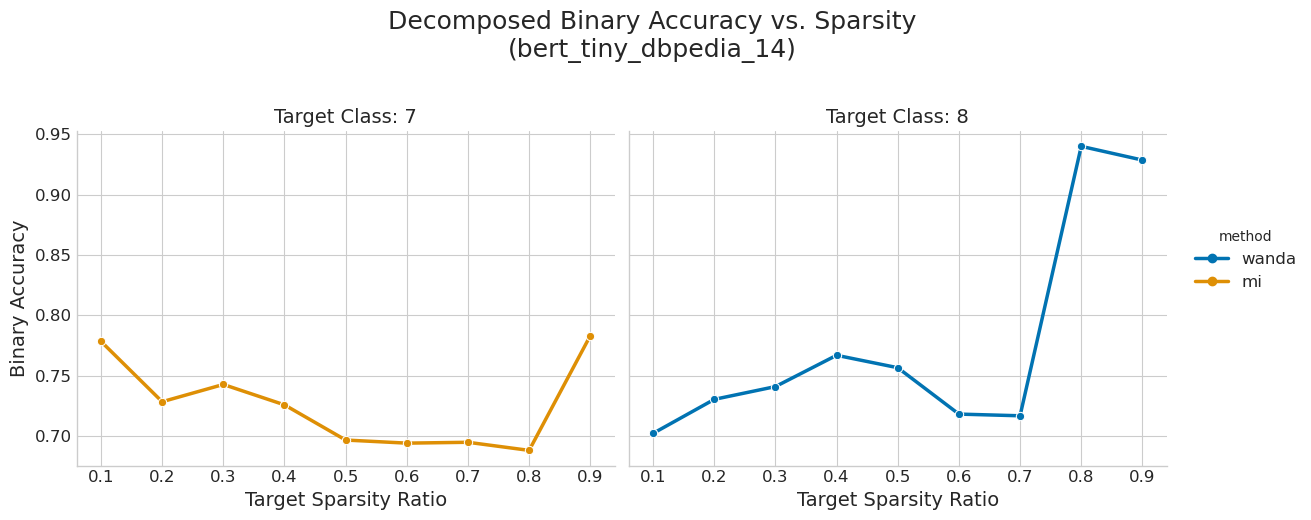

In [ ]:
# Plotting binary (decomposed) accuracy vs. target sparsity for each target class
g = sns.relplot(
    data=data,
    x='target_sparsity',
    y='binary_accuracy',
    hue='method',
    col='binary_target_class', # Create a subplot for each target class
    kind='line',
    marker='o',
    height=5, 
    aspect=1.2,
    linewidth=2.5
)

g.fig.suptitle(f'Decomposed Binary Accuracy vs. Sparsity\n({EXPERIMENT_NAME})', y=1.03, size=18)
g.set_axis_labels('Target Sparsity Ratio', 'Binary Accuracy')
g.set_titles("Target Class: {col_name}")
g.tight_layout(w_pad=1)
plt.show()

## 4. 특정 희소성 레벨에서의 성능 비교

이 막대그래프는 특정 희소성(예: 80%)에서 각 방법론이 타겟 클래스별로 어떤 이진 정확도를 보이는지 요약하여 보여줍니다. 이를 통해 어떤 방법론이 높은 희소성에서도 특정 클래스를 더 잘 분해하는지 한눈에 파악할 수 있습니다.

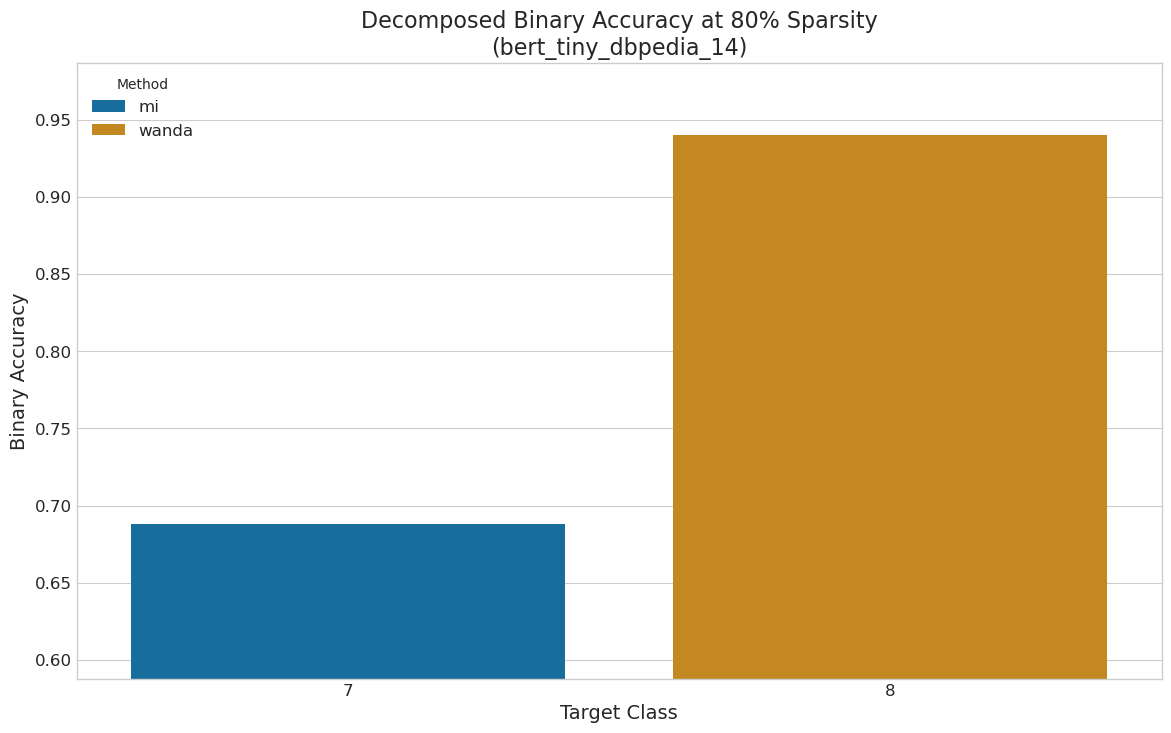

In [15]:
# Compare performance at a specific, high sparsity level
SPARSITY_LEVEL = 0.8

data_at_sparsity = data[data['target_sparsity'] == SPARSITY_LEVEL]

if data_at_sparsity.empty:
    print(f"Warning: No data found for sparsity level {SPARSITY_LEVEL}. Please choose a valid level.")
else:
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=data_at_sparsity,
        x='binary_target_class',
        y='binary_accuracy',
        hue='method'
    )
    
    plt.title(f'Decomposed Binary Accuracy at {int(SPARSITY_LEVEL*100)}% Sparsity\n({EXPERIMENT_NAME})')
    plt.xlabel('Target Class')
    plt.ylabel('Binary Accuracy')
    plt.legend(title='Method')
    plt.ylim(bottom=max(0, data_at_sparsity['binary_accuracy'].min() - 0.1))
    plt.show()

## 5. 정확도 하락률 vs. 희소성

이 그래프는 원본 모델의 정확도(Baseline) 대비 다중 클래스 정확도가 얼마나 감소했는지 보여줍니다. Y축의 값이 0에 가까울수록 성능 보존이 잘 되었음을 의미합니다.

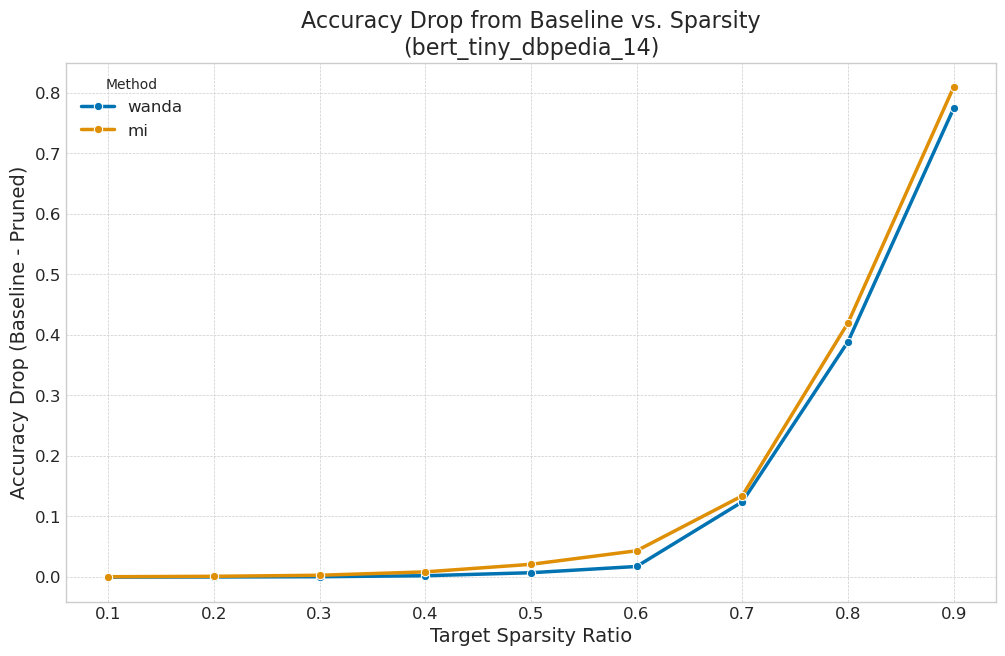

In [16]:
# Calculate accuracy drop from baseline
data['accuracy_drop'] = data['base_accuracy'] - data['accuracy']

plt.figure(figsize=(12, 7))

sns.lineplot(
    data=data.drop_duplicates(subset=['method', 'target_sparsity']),
    x='target_sparsity',
    y='accuracy_drop',
    hue='method',
    marker='o',
    linestyle='-',
    linewidth=2.5
)

plt.title(f'Accuracy Drop from Baseline vs. Sparsity\n({EXPERIMENT_NAME})')
plt.xlabel('Target Sparsity Ratio')
plt.ylabel('Accuracy Drop (Baseline - Pruned)')
plt.legend(title='Method')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()